In [46]:
import itertools
import json

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stopwords = set(nltk.corpus.stopwords.words('english'))
stem_func = nltk.PorterStemmer().stem

df = pd.read_csv('C:/Users/matth/Desktop/ADSProject1/data/philosophy_data.csv')
df['tokenized_txt_list'] = df['tokenized_txt'].apply(
    lambda x: [stem_func(word) for word in json.loads(x.replace("'", "\"")) if word not in stopwords])

df['century'] = (df['original_publication_date'] // 100) * 100
df.loc[df['century'] < 1600, 'century'] = -1000000
df.to_csv('../output/data_with_tokenized_txt.csv', index=False)

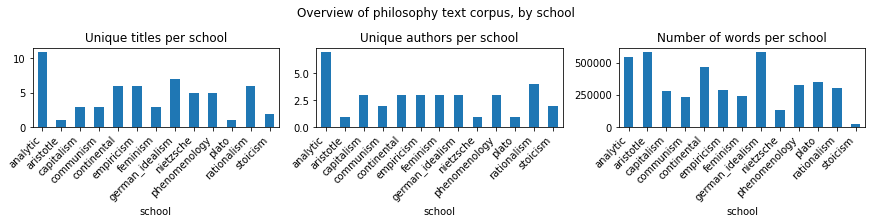

In [263]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(12, 3))
group = 'school'
plt.suptitle(f'Overview of philosophy text corpus, by {group}')

df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

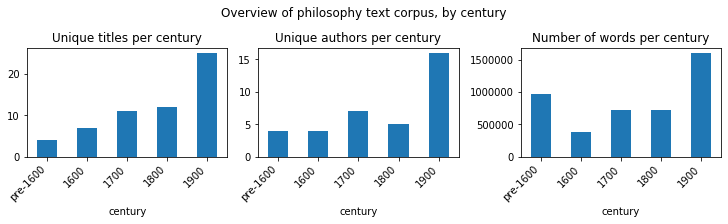

In [262]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3))
group = 'century'
plt.suptitle(f'Overview of philosophy text corpus, by {group}')

df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
    ax[i].set_xticklabels(['pre-1600'] + list(ax[i].get_xticklabels()[1:]), rotation=45, ha='right')

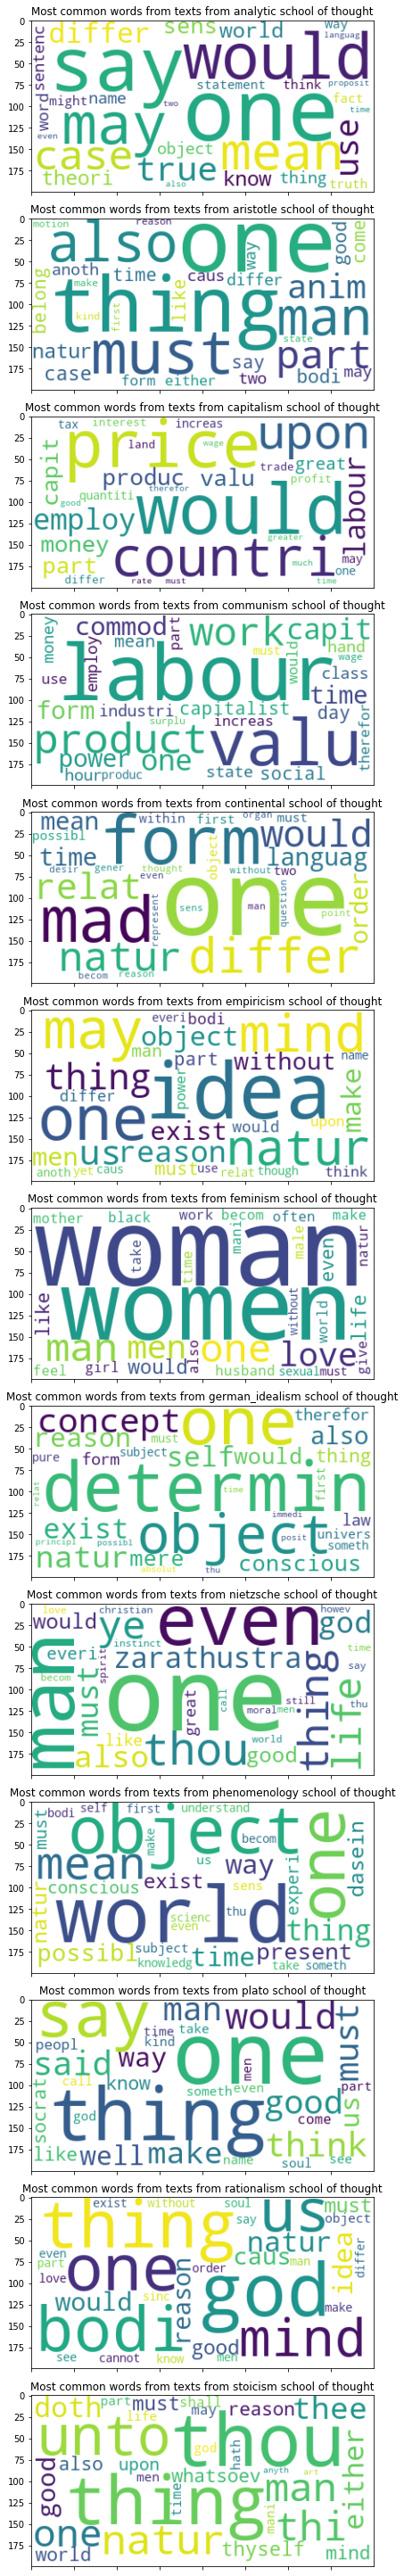

In [295]:
import wordcloud

fig, ax = plt.subplots(nrows=words_by_group.shape[0], figsize=(10, 40), constrained_layout=True)

wcs = []
for i, (group_name, words) in enumerate(words_by_group.iteritems()):
    words, counts = np.unique(words, return_counts=True)
    wc = pd.DataFrame({'word': words, 'count': counts})
    wc = wc[~wc['word'].isin(stopwords)].sort_values('count', ascending=False).iloc[:30,]
    cloud = wordcloud.WordCloud(background_color='white').fit_words(wc.set_index('word')['count'].to_dict())
    ax[i].imshow(cloud, interpolation='bilinear')
    ax[i].set_title(f'Most common words from texts from {group_name} school of thought')

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

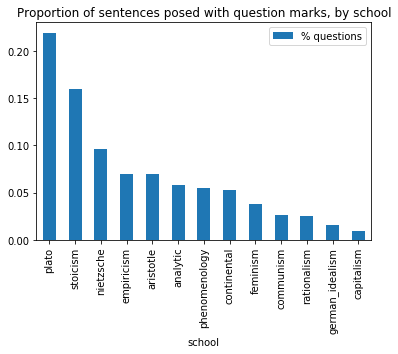

In [125]:
df['question'] = df['sentence_lowered'].str.contains('\?')
q_grouped = df.groupby([group, 'question'])['sentence_lowered'].count() / df.groupby(group)['sentence_lowered'].count()
q_proportions = q_grouped[q_grouped.index.get_level_values('question') == True] \
    .reset_index().drop('question', axis='columns').rename(columns={'sentence_lowered': '% questions'})
q_proportions.sort_values('% questions', ascending=False).plot(
    kind='bar', x=group, y='% questions', title=f'Proportion of sentences posed with question marks, by {group}')

[Text(0, 0, 'pre-1600'),
 Text(0, 0, '1600'),
 Text(0, 0, '1700'),
 Text(0, 0, '1800'),
 Text(0, 0, '1900')]

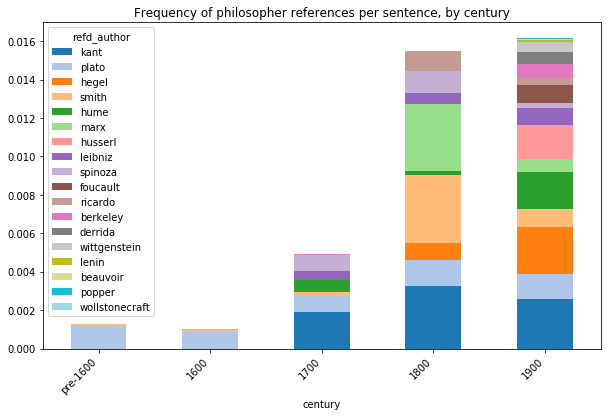

In [330]:
fix, ax = plt.subplots()

authors = set(df['author'].str.lower().unique())
df['refd_authors'] = df['tokenized_txt_list'].apply(lambda l: list(set(l).intersection(authors)))
refd_authors = df.loc[df['refd_authors'].str.len() > 0,
                      ['refd_authors', 'sentence_lowered', 'century']
                     ].explode('refd_authors').rename(columns={'refd_authors': 'refd_author'})

author_freq_order = refd_authors.groupby(['refd_author'])['refd_author'].count().sort_values(ascending=False).index.to_list()
colors = [plt.get_cmap('tab20')(x) for x in np.linspace(0, 1, len(author_freq_order))]
refd_authors_freq = refd_authors.groupby(['century', 'refd_author']).count()['sentence_lowered'] / df.groupby('century')['sentence_lowered'].count()
refd_authors_freq.rename('referenced_authors').unstack()[author_freq_order].plot(
    kind='bar', stacked=True, figsize=(10, 6), title='Frequency of philosopher references per sentence, by century', color=colors, ax=ax)
ax.set_xticklabels(['pre-1600'] + list(ax.get_xticklabels()[1:]), rotation=45, ha='right')